## Preface
The majority of the code in this notebook is taken from <br>
1: [BERT with HuggingFace Transformers, kaggle](https://www.kaggle.com/code/tuckerarrants/bert-with-huggingface-transformers) <br>
2: [BERT Fine-Tuning Tutorial with PyTorch
By Chris McCormick and Nick Ryan, google colab](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP?usp=sharing)

# Importing library and checking GPU

In [ ]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf

In [ ]:
#!pip install torch
#!pip install transformers

In [ ]:
import torch
print(torch.__version__)

2.3.0+cu121


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
import transformers

Installing Hugging face lib, but look like they already interaged in

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
df = pd.read_excel('PHQ9DepressionNLP_elaborated.xlsx')

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 520



,AcademicDescription,ViolenceDescription,SocialDescription,PHQDescription,GeneralDescription,PressureDescription,PHQ9_levels
430,I am currently in my 1 year with a CGPA of 2.0...,I Strongly disagree that I experienced physic...,I Neutral that My understanding with my paren...,"I often feel a lack of interest in activities,...","I am 20 years old, studying in my 1 year with ...",I Neutral that my Parents are Strict. I Agre...,Moderate
509,I am currently in my 1 year with a CGPA of 3.6...,"I Agree that I experienced physical violence,...",I Agree that My understanding with my parents...,"I often feel a lack of interest in activities,...","I am 21 years old, studying in my 1 year with ...",I Neutral that my Parents are Strict. I Disa...,Moderate
98,I am currently in my 3 year with a CGPA of 3.0...,"I Agree that I experienced physical violence,...",I Strongly agree that My understanding with m...,"I often feel a lack of interest in activities,...","I am 23 years old, studying in my 3 year with ...",I Strongly agree that my Parents are Strict. ...,Moderate
314,I am currently in my 3 year with a CGPA of 3.4...,I Disagree that I experienced physical violen...,I Agree that My understanding with my parents...,"I often feel a lack of interest in activities,...","I am 23 years old, studying in my 3 year with ...",I Strongly agree that my Parents are Strict. ...,Moderate
352,I am currently in my 1 year with a CGPA of 2.1...,I Strongly disagree that I experienced physic...,I Strongly disagree that My understanding wit...,"I often feel a lack of interest in activities,...","I am 19 years old, studying in my 1 year with ...",I Strongly agree that my Parents are Strict. ...,ModeratelySevere
212,I am currently in my 1 year with a CGPA of 4.0...,"I Agree that I experienced physical violence,...",I Neutral that My understanding with my paren...,"I often feel a lack of interest in activities,...","I am 20 years old, studying in my 1 year with ...",I Agree that my Parents are Strict. I Disagr...,Moderate
434,I am currently in my 4 year with a CGPA of 3.4...,I Neutral that I experienced physical violenc...,I Disagree that My understanding with my pare...,"I often feel a lack of interest in activities,...","I am 22 years old, studying in my 4 year with ...",I Neutral that my Parents are Strict. I Disa...,Moderate
205,I am currently in my 4 year with a CGPA of 3.1...,I Disagree that I experienced physical violen...,I Strongly disagree that My understanding wit...,"I often feel a lack of interest in activities,...","I am 24 years old, studying in my 4 year with ...",I Disagree that my Parents are Strict. I Dis...,Moderate
302,I am currently in my 4 year with a CGPA of 3.5...,"I Agree that I experienced physical violence,...",I Agree that My understanding with my parents...,"I often feel a lack of interest in activities,...","I am 26 years old, studying in my 4 year with ...",I Agree that my Parents are Strict. I Agree ...,Severe
293,I am currently in my 1 year with a CGPA of 3.6...,I Neutral that I experienced physical violenc...,I Agree that My understanding with my parents...,"I often feel a lack of interest in activities,...","I am 20 years old, studying in my 1 year with ...",I Agree that my Parents are Strict. I Agree ...,Mild


# Preprocessing

In [ ]:
# Define the mapping from category to integer
encoding_map = {
    'Minimal': 0,
    'Mild': 1,
    'Moderate': 2,
    'ModeratelySevere' : 3,
    'Severe': 4,
}

# Apply the mapping to the DataFrame
df['PHQ9_levels'] = df['PHQ9_levels'].replace(encoding_map)

In [ ]:
df.head()

,AcademicDescription,ViolenceDescription,SocialDescription,PHQDescription,GeneralDescription,PressureDescription,PHQ9_levels
0,I am currently in my 4 year with a CGPA of 3.3...,I Disagree that I experienced physical violen...,I Disagree that My understanding with my pare...,"I often feel a lack of interest in activities,...","I am 23 years old, studying in my 4 year with ...",I Agree that my Parents are Strict. I Agree ...,0
1,I am currently in my 1 year with a CGPA of 3.0...,I Disagree that I experienced physical violen...,I Disagree that My understanding with my pare...,"I often feel a lack of interest in activities,...","I am 24 years old, studying in my 1 year with ...",I Disagree that my Parents are Strict. I Dis...,0
2,I am currently in my 4 year with a CGPA of 3.0...,I Neutral that I experienced physical violenc...,I Agree that My understanding with my parents...,"I often feel a lack of interest in activities,...","I am 24 years old, studying in my 4 year with ...",I Neutral that my Parents are Strict. I Disa...,0
3,I am currently in my 1 year with a CGPA of 3.8...,"I Agree that I experienced physical violence,...",I Strongly disagree that My understanding wit...,"I often feel a lack of interest in activities,...","I am 22 years old, studying in my 1 year with ...",I Neutral that my Parents are Strict. I Neut...,0
4,I am currently in my 4 year with a CGPA of 3.4...,I Disagree that I experienced physical violen...,I Disagree that My understanding with my pare...,"I often feel a lack of interest in activities,...","I am 25 years old, studying in my 4 year with ...",I Strongly disagree that my Parents are Stric...,2


In [ ]:
df['PHQ9_levels'].unique()

array([0, 2, 1, 3, 4])

In [ ]:
sentences = df['SocialDescription'].values
labels = df['PHQ9_levels'].values

# Train Test Val split

In [ ]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)

In [ ]:
test, validation = train_test_split(temp, random_state=1508, shuffle=True, test_size=0.5)

In [ ]:
# Get the lists of sentences and their labels.
trn_sentences = train['SocialDescription'].values
train_labels = train['PHQ9_levels'].values

tst_sentences = test['SocialDescription'].values
test_labels = test['PHQ9_levels'].values

val_sentences = validation['SocialDescription'].values
validation_labels = validation['PHQ9_levels'].values

## tokenization

In [ ]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


print('loading ALBERT tokenizer...')
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2', do_lower_case=True)


loading ALBERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
enc_exp = tokenizer.encode('My name is Leon and I am definitely not depressed')
dec_exp = tokenizer.decode(enc_exp)
print(enc_exp)
print(dec_exp)

[2, 51, 204, 25, 4218, 17, 31, 589, 4939, 52, 17369, 3]
[CLS] my name is leon and i am definitely not depressed[SEP]


## padding & masking

In [ ]:
print('Max array length: ', max([len(i) for i in sentences]))

Max array length:  550


In [ ]:
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>200:
        count1+=1
    if len(i)>300:
        count2+=1
    if len(i)>550:
        count3+=1
print('number of array longer than 200: ', count1)
print('number of array longer than 300: ', count2)
print('number of array longer than 550: ', count3)

number of array longer than 200:  520
number of array longer than 300:  520
number of array longer than 550:  0


In [ ]:
from statistics import mean
token_len = []
for i in sentences:
    if len(i)>0 and len(i)<600:
        enc = tokenizer.encode(i)
        token_len.append(len(enc))
print('average token length: ', mean(token_len))
print('maximum token length: ', max(token_len))

average token length:  106.63846153846154
maximum token length:  112




--output--
average token length: 357
maximum token length: 474


In [ ]:
count = 0
for i in token_len:
    if i > 100:
        count+=1
print('number of sentence longer than 200 words:', count)

number of sentence longer than 200 words: 520


In [ ]:
count = 0
for i in token_len:
    if i > 150:
        count+=1
print('number of sentence longer than 270 words:', count)

number of sentence longer than 270 words: 0


--output-- <br>
number of sentence longer than 200 words: 0
number of sentence longer than 270 words: 506

In [ ]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []


    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [ ]:
print(len(sentences),len(trn_sentences),len(tst_sentences),len(val_sentences))

520 416 52 52


In [ ]:
MAX_LEN = 150
train_inputs, train_masks = bert_encode(trn_sentences,MAX_LEN)

test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

validation_inputs, validation_masks = bert_encode(val_sentences,MAX_LEN)

## convert data to pytorch datatype

In [ ]:
# Convert data to tensors and immediately send to the device
train_inputs = torch.tensor(train_inputs).to(device)
validation_inputs = torch.tensor(validation_inputs).to(device)

train_labels = torch.tensor(train_labels).to(device)
validation_labels = torch.tensor(validation_labels).to(device)

train_masks = torch.tensor(train_masks).to(device)
validation_masks = torch.tensor(validation_masks).to(device)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BERT for sequence classification

In [ ]:
# Ensure the model is on the same device as the inputs and labels
model = AlbertForSequenceClassification.from_pretrained(
    "albert-base-v2", # Use the ALBERT model.
    num_labels=5, # The number of output labels.
    output_attentions=False, # Whether the model returns attentions weights.
    output_hidden_states=False, # Whether the model returns all hidden-states.
).to(device)  # Move the model to the device

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-8.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 30 #at least 20

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## training loop

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 30 ========
Training...

  Average training loss: 1.52
  Training epcoh took: 0:00:12

Running Validation...
  Accuracy: 0.44
  Validation took: 0:00:01

======== Epoch 2 / 30 ========
Training...

  Average training loss: 1.44
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.45
  Validation took: 0:00:01

======== Epoch 3 / 30 ========
Training...

  Average training loss: 1.38
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.34
  Validation took: 0:00:01

======== Epoch 4 / 30 ========
Training...

  Average training loss: 1.41
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.44
  Validation took: 0:00:01

======== Epoch 5 / 30 ========
Training...

  Average training loss: 1.39
  Training epcoh took: 0:00:11

Running Validation...
  Accuracy: 0.46
  Validation took: 0:00:01

======== Epoch 6 / 30 ========
Training...

  Average training loss: 1.40
  Training epcoh took: 0:00:11

Running Validation...
  Accu

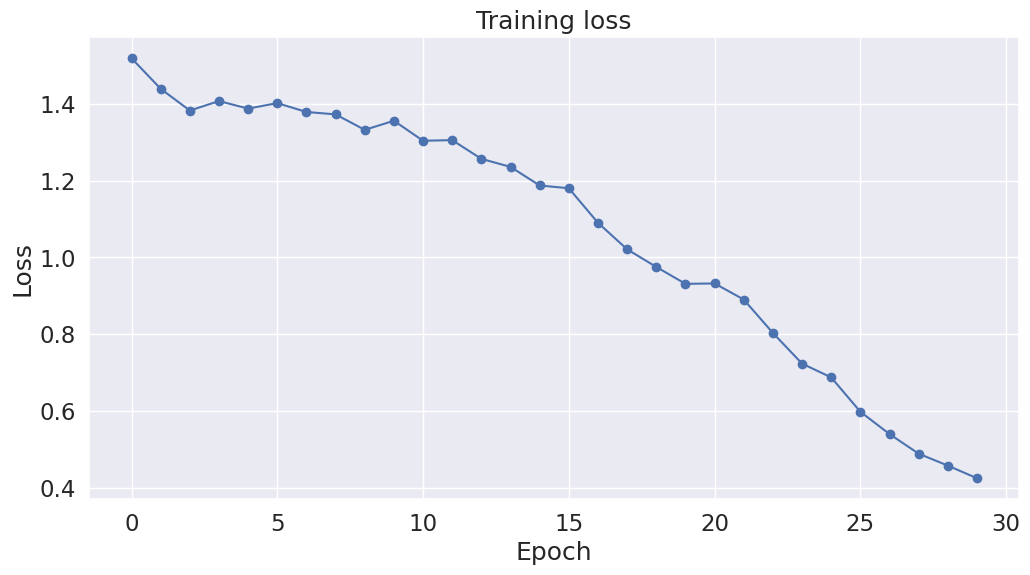

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# On test set

In [ ]:
test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 52 test sentences...
    DONE.


## Matthew's correlation coefficient
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 3-column ndarray (one column for "0"
  # one for "1" and one for "2"). Pick the label with the highest value and turn this
  # in to a list of 0s, 1s, 2s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

In [ ]:
# Combine the predictions for each batch into a single list of 0s,1s, 2s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate accuracy

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.215


In [ ]:
from sklearn.metrics import accuracy_score
# Calculate accuracy
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.423


## confusion matrix

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.59      0.50      0.54        20
           1       0.39      0.47      0.42        15
           2       0.23      0.38      0.29         8
           3       1.00      0.14      0.25         7
           4       0.33      0.50      0.40         2

    accuracy                           0.42        52
   macro avg       0.51      0.40      0.38        52
weighted avg       0.52      0.42      0.42        52

